In [3]:
import os, sys, wave, struct
import numpy as np
import platform
import matplotlib.pyplot as plt
import scipy.signal as signal
from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from IPython.display import display, Audio
import scipy    
import time
import soundfile as sf
from math import ceil, exp, atan, pi, cos, sin
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pylab as p

In [14]:
import scipy.io

fichier = '5_fingertip_14_6_E_nylon_horizontal_malena.mat'
mat_data = scipy.io.loadmat(fichier) 
sorted(mat_data)
sorted(mat_data.keys())
print(mat_data)
a = 160000
temps = mat_data['temps'].T
temps = temps[0][a:]
vertical = mat_data['signal_vertical'].T
vertical = vertical[0][a:]
horizontal = mat_data['signal_horizontal'].T
horizontal = horizontal[0]

Fe = 1/(temps[1]-temps[0])
print(Fe)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Apr 13 16:25:56 2023', '__version__': '1.0', '__globals__': [], 'signal_horizontal': array([[0.63614607],
       [0.63631632],
       [0.63606186],
       ...,
       [0.66158706],
       [0.66232662],
       [0.66282759]]), 'signal_vertical': array([[0.84124268],
       [0.84128109],
       [0.84095916],
       ...,
       [0.88951885],
       [0.88899876],
       [0.88842136]]), 'temps': array([[0.00000000e+00],
       [1.95312500e-05],
       [3.90625000e-05],
       ...,
       [4.99994141e+00],
       [4.99996094e+00],
       [4.99998047e+00]]), 'trigger': array([[0.05610039],
       [0.05595767],
       [0.05606013],
       ...,
       [0.05596133],
       [0.05604428],
       [0.05596804]])}
51200.000000046566


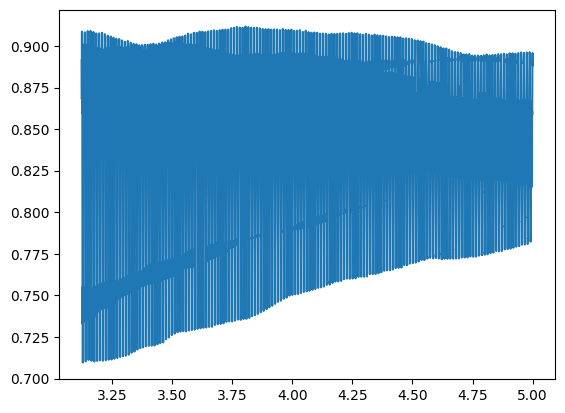

In [15]:
plt.plot(temps, vertical)

In [16]:
#Paramètres initiaux
n=1000
K= 50

#Fonction LeastSquare
def LeastSquare(x_,delta_,f_):
    #Estimation des amplitudes et des phases
    N_=len(x_)
    K_=len(f_)
    t_ =np.arange(0,N_)
    k=np.arange(0,K_)

    #calcul de Vn

    log_V_N= t_[:,None]*(delta_+2j*np.pi*f_)
    V_N=np.exp(log_V_N)
    print(V_N.shape)

    #alpha =
    alpha =np.linalg.pinv(V_N)@x_

    #calcul a
    a=np.abs(alpha)
    phi =np.angle(alpha)
    
    return a,phi

def ESPRIT(x_,n_,K_):
    
    N_ = len(x_)
    l_ = N_-n_+1


    X=scipy.linalg.hankel(x_[:n],x_[n_-1:N_])
    
    
    #Matrice Rxx
    Rxx=(1/l_)*(X@(np.conjugate(X.T)))

    #diagonalisation
    U1,Lambda,U2 = np.linalg.svd(Rxx)
    plt.plot(np.abs(Lambda))
    plt.show()
    
    #Création de W
    W=U1[:,:K_]

    W_down=W[:-1,:]
    W_up=W[1:,:]


    #création de phi
    phi_ = np.linalg.pinv(W_down)@W_up

    #calcul de ses valeurs propres
    z_ =np.linalg.eig(phi_)[0]
    delta_=np.log(np.abs(z_))
    f_= (1/(2*np.pi))*np.angle(z_)
    
    a_,phi_ = LeastSquare(x_,delta_,f_)
    return delta_, f_, a_, phi_

def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s


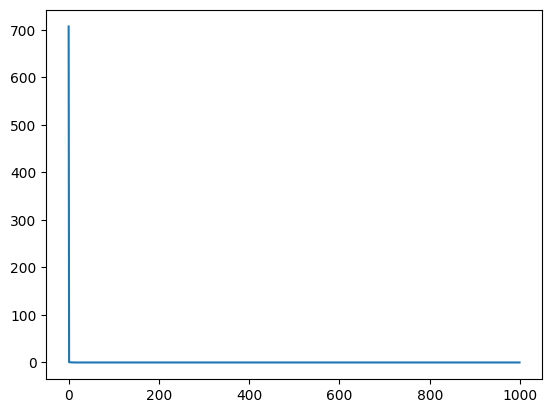

(96000, 50)
[-2.18545442e+00 -2.18545442e+00 -2.21638735e+00 -2.21638735e+00
 -1.40611191e+00 -1.40611191e+00 -1.94797943e+00 -1.94797943e+00
 -1.12892454e+00 -1.12892454e+00 -1.80748665e+00 -1.80748665e+00
 -7.32156873e-01 -7.32156873e-01 -1.10328492e+00 -1.10328492e+00
 -7.48034037e-01 -7.48034037e-01 -8.96179674e-01 -8.96179674e-01
 -9.06200019e-01 -9.06200019e-01 -7.45631230e-01 -7.45631230e-01
 -8.16070686e-01 -8.16070686e-01 -5.90958870e-01 -5.90958870e-01
 -2.35504880e-01 -2.35504880e-01 -1.16863154e+00 -1.16863154e+00
 -4.59409854e-01 -4.59409854e-01 -3.01523322e-01 -3.01523322e-01
 -5.07205227e-01 -5.07205227e-01 -1.71339234e-01 -1.71339234e-01
 -5.13542504e-01 -5.13542504e-01 -7.39580692e-01 -7.39580692e-01
 -1.84296336e-01 -1.84296336e-01 -2.29504902e-01 -2.29504902e-01
  4.79118171e-05 -7.02741336e+00]
[ 2190.73328512 -2190.73328512  2099.73308971 -2099.73308971
  1849.1063991  -1849.1063991   1764.20974308 -1764.20974308
  1679.63973595 -1679.63973595  1595.61389365 -1595.

In [19]:
N = len(vertical)
delta_est,f_est, a_est, phi_est = ESPRIT(vertical,n,K)

x_est=Synthesis(N,delta_est,f_est, a_est, phi_est)

print(delta_est*Fe)
print(f_est*Fe)

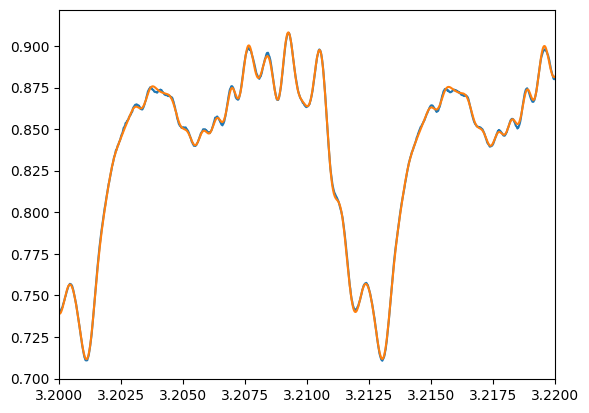

In [18]:
plt.plot(temps,np.real(vertical))

plt.plot(temps,np.real(x_est))
plt.xlim(3.2,3.22)
plt.show()

In [20]:
import librosa 

print(librosa.yin(vertical, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')))

[2205.           88.55048821   77.81839352   65.23668639   65.75787335
   65.23668639   65.23668639   79.44065444   79.08237001   66.49628146
   68.37956847   66.02454163   65.23668639   80.61504145   78.08592092
   69.01573328   65.23668639   66.32457181   65.23668639   84.44193799
   78.23893561   71.91372098   66.31560558   66.05305574   65.23668639
   88.80270313   79.11000864   74.2342637    65.23668639   67.11131033
   65.6245585    65.76020116   80.3042872    76.42004336   65.23668639
   66.61671896   65.23668639   65.23668639   80.11640074   77.57275941
   65.23668639   68.74612974   65.35916809   65.23668639   79.43028039
   78.11587985   66.40079571   68.18600407   66.36020689   65.23668639
   81.7109982    77.8575635    69.27172655   70.0950134    66.49862818
   65.23668639   84.05438519   78.17215513   71.41070959   69.115603
   66.30252841   65.33648089   88.02838327   78.86663759   73.14377785
   65.7215843    66.55475426   65.7483738    69.95181165   79.54072347
   75.40